In [181]:
# Useful starting lines
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
%load_ext autoreload
%autoreload 2
from algorithms import *
#import math

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [182]:
test_ls_grid_GD_SGD()

Gradient Descent(8/499): loss=15.385899822261674, w0=73.29247935783842, w1=13.47944711380919, cost: mse
Gradient Descent(18/499): loss=4.424632224699847, w0=73.24, w1=13.526244743050533, cost: mae
Gradient Descent(99/99): loss=15.81808716666469, w0=73.49888060593705, w1=14.099226004457082, cost: mse
Gradient Descent(99/99): loss=4.4771184974747, w0=73.1, w1=13.51852484146829, cost: mae
ls_w: [ 73.293922    13.47971243]
grid_w: [73.737373737373758, 13.131313131313135]
GD_w: [ 73.29247936  13.47944711]
GD_w_mae: [ 73.24        13.52624474]
SGD_w: [ 73.54790358  12.64605264]
SGD_w_mae [ 73.6         13.54844369]


0

# Cross-Validation and Bias-Variance decomposition
## Cross-Validation
Implementing 4-fold cross-validation below:

In [183]:
from helpers import load_data

# load dataset
x, y = load_data()

In [184]:
def build_k_indices(y, k_fold, seed):
    """build k indices for k-fold."""
    num_row = y.shape[0]
    interval = int(num_row / k_fold)
    np.random.seed(seed)
    indices = np.random.permutation(num_row)
    k_indices = [indices[k * interval: (k + 1) * interval]
                 for k in range(k_fold)]
    return np.array(k_indices)

In [185]:
y.shape[0]

50

In [186]:
k_fold=4
k=3
k_indices = build_k_indices(y, k_fold, seed=1)
print(k_indices)
test_indices = k_indices[k-1]
print(type(k_indices))
#np.concatenate(k_indices[:k], k_indices[k+1:])
k_indices[:k]
k_indices[k+1:]
training_indices = k_indices[[x for x in range(k_indices.shape[0]) if x != k]]
print(np.ravel(training_indices))
#x[k_indices[[x for x in range(k_indices.shape[0]) if x != k]]]

[[27 35 40 38  2  3 48 29 46 31 32 39]
 [21 36 19 42 49 26 22 13 41 17 45 24]
 [23  4 33 14 30 10 28 44 34 18 20 25]
 [ 6  7 47  1 16  0 15  5 11  9  8 12]]
<class 'numpy.ndarray'>
[27 35 40 38  2  3 48 29 46 31 32 39 21 36 19 42 49 26 22 13 41 17 45 24 23
  4 33 14 30 10 28 44 34 18 20 25]


In [187]:
#from costs import compute_mse
#from ridge_regression import ridge_regression
#from build_polynomial import build_poly

def cross_validation(y, x, k_indices, k, lambda_, degree):
    """return the loss of ridge regression."""
    
    test_indices = k_indices[k]
    x_test = x[test_indices]
    y_test = y[test_indices]
    
    train_indices = k_indices[[x for x in range(k_indices.shape[0]) if x != k]]
    x_train = x[np.ravel(train_indices)]
    y_train = y[np.ravel(train_indices)]

    
    tx_test = build_poly(x_test, degree)
    tx_train = build_poly(x_train, degree)
    
    loss_ridge_train, w = ridge_regression(y_train, tx_train, lambda_)
    
    loss_train = compute_loss(y_train, tx_train, w, cost = "mse", lambda_ = lambda_)

    loss_test = compute_loss(y_test, tx_test, w, cost = "mse", lambda_ = lambda_)

    return loss_train, loss_test

In [188]:
y.shape

(50,)

In [220]:
from plots import cross_validation_visualization

def cross_validation_demo(y, x, degree, k_fold, seed):
    lambdas = np.logspace(-4, 0, 30)
    # split data in k fold
    k_indices = build_k_indices(y, k_fold, seed)
    # define lists to store the loss of training data and test data
    rmse_tr = []
    rmse_te = []
    
    min_rmse_te = math.inf
    for lambda_ in lambdas:
        tmp_rmse_tr = []
        tmp_rmse_te = []
        for k in range(k_fold):
            loss_train, loss_test = cross_validation(y, x, k_indices, k, lambda_, degree)
            tmp_rmse_tr += [np.sqrt(2 * loss_train)]
            tmp_rmse_te += [np.sqrt(2 * loss_test)]
        
        new_rmse_tr = sum(tmp_rmse_tr) / k_fold
        new_rmse_te = sum(tmp_rmse_te) / k_fold
        new_rmse_te_std = np.std(np.array(tmp_rmse_te))
        
        rmse_tr += [new_rmse_tr]
        rmse_te += [new_rmse_te]
        rmse_te_std = [new_rmse_te_std]
        
        if (new_rmse_te < min_rmse_te):
            best_lambda = lambda_
            min_rmse_te = new_rmse_te

    plt = cross_validation_visualization(lambdas, rmse_tr, rmse_te)
    plt.errorbar(lambdas, rmse_te, yerr=ss.t.ppf(0.95, [k_fold] * len(rmse_te)) * rmse_te_std)
    return best_lambda


In [221]:
x.shape

(50,)

0.0045203536563602409

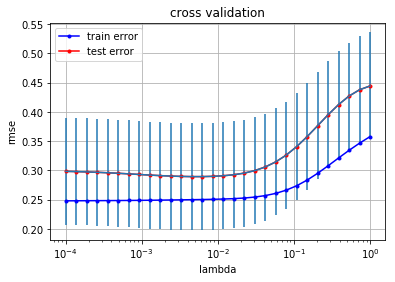

In [222]:
degree = 7
k_fold = 4
seed = 1
cross_validation_demo(y, x, degree, k_fold, seed)

In [205]:
def cross_validation_best_degree_lambda(y, x, degree, k_fold, seed, lambda_min = -4, lambda_max = 0, nb_lambda = 30):
    lambdas = np.logspace(lambda_min, lambda_max, nb_lambda)
    # split data in k fold
    k_indices = build_k_indices(y, k_fold, seed)
    # define lists to store the loss of training data and test data
    
    #rmse_tr_d = []
    #rmse_te_d = []
    
    
    min_rmse_te = math.inf
    for d in degree:
        rmse_tr = []
        rmse_te = []
        for lambda_ in lambdas:
            tmp_rmse_tr = []
            tmp_rmse_te = []
            for k in range(k_fold):
                loss_train, loss_test = cross_validation(y, x, k_indices, k, lambda_, d)
                tmp_rmse_tr += [np.sqrt(2 * loss_train)]
                tmp_rmse_te += [np.sqrt(2 * loss_test)]
    
            new_rmse_tr = sum(tmp_rmse_tr) / k_fold
            new_rmse_te = sum(tmp_rmse_te) / k_fold

            if (abs(lambda_ - 0.00452) < 1e-3):
                rmse_tr_d += [new_rmse_tr]
                rmse_te_d += [new_rmse_te]
            
            #rmse_tr += [new_rmse_tr]
            #rmse_te += [new_rmse_te]

            if (new_rmse_te < min_rmse_te):
                best_lambda = lambda_
                best_degree = d
                min_rmse_te = new_rmse_te
                
        #if (d == degree[0] or d == degree[len(degree) // 2] or d == degree[len(degree)-1] or d==7):
            #cross_validation_visualization(lambdas, rmse_tr, rmse_te)
            #plt.figure()
    #print("degree:",rmse_tr_d)
    #plt.scatter(degree, rmse_tr_d)
    #plt.scatter(degree, rmse_te_d)   
    
    return best_degree, best_lambda
            
    
    
    
    

degree: [0.46021074347046259, 0.26818495451378849, 0.26227515447424576, 0.25543743128668606, 0.25406650996666652, 0.25017964079198551, 0.24876984863272794, 0.2487437421902543, 0.24614212842855182]


(7, 0.0045203536563602409)

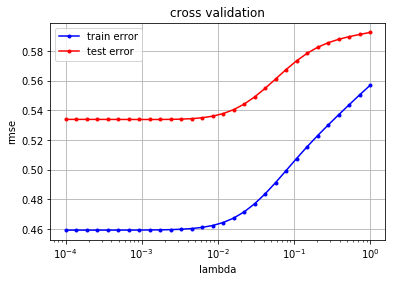

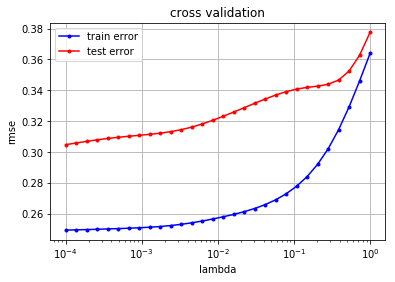

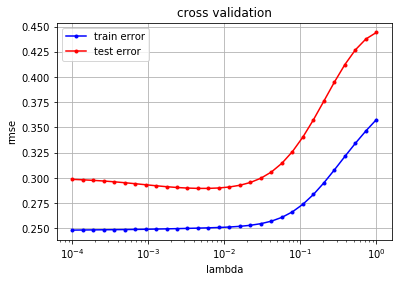

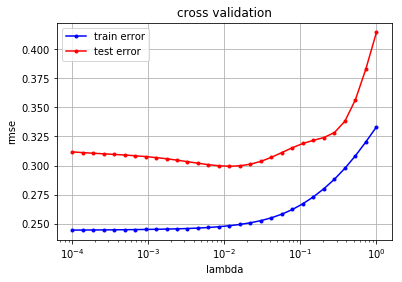

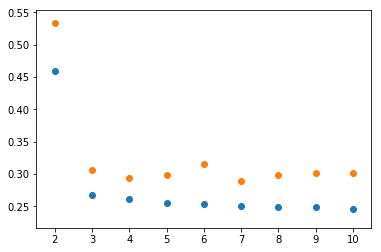

In [206]:
k_fold = 4
seed = 1
degree = np.arange(2,11)
cross_validation_best_degree_lambda(y, x, degree, k_fold, seed)

## Bias-Variance Decomposition
Visualize bias-variance trade-off by implementing the function `bias_variance_demo()` below:

In [218]:
#from least_squares import least_squares
#from split_data import split_data
from plots import bias_variance_decomposition_visualization

def bias_variance_demo():
    """The entry."""
    # define parameters
    seeds = range(100)
    num_data = 10000
    ratio_train = 0.005
    degrees = range(1, 10)
    
    # define list to store the variable
    rmse_tr = np.empty((len(seeds), len(degrees)))
    rmse_te = np.empty((len(seeds), len(degrees)))
    
    for index_seed, seed in enumerate(seeds):
        np.random.seed(seed)
        x = np.linspace(0.1, 2 * np.pi, num_data)
        y = np.sin(x) + 0.3 * np.random.randn(num_data).T
        
        [x_train, y_train], [x_test, y_test] = split_data(x, y, ratio_train, seed)
        for index_d, d in enumerate(degrees):
            tx_train = build_poly(x_train, d)
            tx_test = build_poly(x_test, d)
            loss, w = least_squares(y_train, tx_train)
        
            mse_tr = compute_loss(y_train, tx_train, w, cost = "mse")
            mse_te = compute_loss(y_test, tx_test, w, cost = "mse")

            rmse_tr[index_seed, index_d] = np.sqrt(2*mse_tr)
            rmse_te[index_seed, index_d] = np.sqrt(2*mse_te)
        
    bias_variance_decomposition_visualization(degrees, rmse_tr, rmse_te)



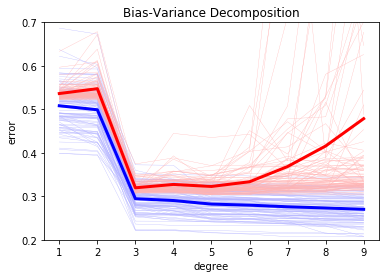

In [219]:
bias_variance_demo()

In [241]:
def averaged_cross_validation_best_degree_lambda(y, x, degrees, k_fold, nb_seed = 100, \
                                                 lambda_min = -4, lambda_max = 0, nb_lambda = 30, plot = False):
    lambdas = np.logspace(lambda_min, lambda_max, nb_lambda)
    
    seeds = range(nb_seed)
    
    # define list to store the variable
    rmse_te = np.empty((len(seeds), len(degrees), len(lambdas)))    
    
    for ind_seed, seed in enumerate(seeds):
        k_indices = build_k_indices(y, k_fold, seed)
        for ind_d, d in enumerate(degrees):
            for ind_lambda_, lambda_ in enumerate(lambdas):
                tmp_rmse_te = []
                for k in range(k_fold):
                    loss_test = cross_validation(y, x, k_indices, k, lambda_, d)[1]
                    tmp_rmse_te += [np.sqrt(2 * loss_test)]

                rmse_te[ind_seed, ind_d, ind_lambda_] = sum(tmp_rmse_te) / k_fold


    rmse_te_mean = np.mean(rmse_te, axis=0)
    
    best_index = np.argmin(rmse_te_mean)
    best_ind_d = best_index // len(lambdas)
    best_ind_lambda = best_index % len(lambdas)
    
    if (plot == True):
        plt.plot(degrees, rmse_te_mean[:, best_ind_lambda], marker=".", color='r', label='test error')
        plt.xlabel("degree")
        plt.ylabel("rmse")
        plt.title("cross validation")
        plt.legend(loc=2)
        plt.grid(True)
        plt.savefig("cross_validation")

        plt.figure()
        plt.semilogx(lambdas, rmse_te_mean[best_ind_d], marker=".", color='r', label='test error')
        plt.xlabel("lambda")
        plt.ylabel("rmse")
        plt.title("cross validation")
        plt.legend(loc=2)
        plt.grid(True)
        plt.savefig("cross_validation")
    
    best_degree = degrees[best_ind_d]
    best_lambda = lambdas[best_ind_lambda]
    
    return best_degree, best_lambda
    
    
    
    

In [242]:
degrees = range(2,10)
averaged_cross_validation_best_degree_lambda(y, x, degrees, k_fold, nb_seed = 100, \
                                                 lambda_min = -4, lambda_max = 0, nb_lambda = 30)

(4, 0.0012689610031679222)